# Задание #1

## Описание задания

В сообществах появилась возможность создавать чаты для общения. Чтобы помочь пользователям начать активно использовать эту фичу, при создании сообщества администратору показывается блок с беседами, даже если их пока нет. Нужно оценить эффективность этих нововведений. Для этого необходимо узнать, какой процент сообществ создают групповые чаты в течение 7 суток с момента образования сообщества.

Дана таблица со следующей структурой:

```sql
create table community_actions (
    `time` DateTime, -- время
    `dt` Date, -- дата
    `user_id` Int32, -- идентификатор пользователя
    `community_id` Int32, -- идентификатор сообщества 
    `community_registered_time` DateTime, -- время образования сообщества
    `event` String -- действие
)
```

В поле ‘event’ содержатся два вида событий:
* 'CREATE_COMMUNITY' — создание сообщества,
* 'CREATE_CHAT' — создание чата.

Необходимо написать SQL-запрос, который возвращал бы процент сообществ, создающих чаты в течение 7 суток с момента своего создания, сгруппированные по дням. Интересующий период наблюдения: последние 60 суток с текущего времени.

## Ответ сразу:

```sql
SELECT
    DateDiff('day', community_registered_time, dt) AS days,
    COUNT(*) / (
        SELECT COUNT(*) 
        FROM vk_task_core.community_actions 
        WHERE DateDiff('day', community_registered_time, now()) <= 60 and event == 'CREATE_CHAT'
    ) * 100
FROM vk_task_core.community_actions
WHERE
    DateDiff('day', community_registered_time, now()) <= 60
    and event == 'CREATE_CHAT'
    and days <= 7
GROUP BY days
ORDER BY days
```

### Пояснение

In [1]:
import requests
import pandas as pd
from io import StringIO
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
import numpy as np
import seaborn as sns

In [2]:
# Функции запросов к БД

host = 'http://localhost:8123'
username = 'default'
password = '123'

def get_query_response(query, host=host, username=username, password=password):
    r = requests.post(host, data=query, auth=(username, password))
    return r.text

def get_data(query):
    r = get_query_response(query)
    return pd.read_csv(StringIO(r), sep='\t', header=None)

#### Создание базы данных

In [3]:
# На всякий случай удалю таблицу
get_query_response('DROP TABLE IF EXISTS vk_task_core.community_actions')
# Создаю таблицу
get_query_response('CREATE DATABASE IF NOT EXISTS vk_task_core')
get_query_response("""
create table IF NOT EXISTS vk_task_core.community_actions (
    `time` DateTime,
    `dt` Date,
    `user_id` Int32,
    `community_id` Int32, 
    `community_registered_time` DateTime,
    `event` String
)
ENGINE = MergeTree()
ORDER BY time
""");

In [4]:
# даты создания сообществ

comunities_per_day = 500 # количество сообществ, создаваемых в день
total_comunities = 3 * 30 * comunities_per_day # всего сообществ в базе данных

comunity_creation_dates = [datetime.now() - timedelta(days=i // comunities_per_day)
                           for i in range(total_comunities)]

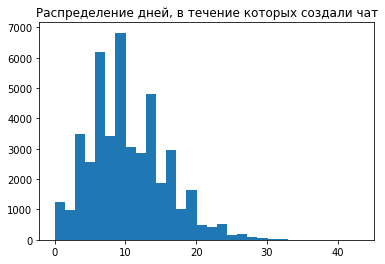

In [5]:
# Задаю даты создания чатов skewnorm распределением
chat_creation_deltas = skewnorm.rvs(2.4, loc=5, scale=8, size=total_comunities, random_state=42).astype(int)
chat_creation_deltas = np.abs(chat_creation_deltas)
chat_creation_dates = [d + timedelta(int(delta)) for d, delta in zip(comunity_creation_dates, chat_creation_deltas)]

plt.hist(chat_creation_deltas, bins=30)
plt.title('Распределение дней, в течение которых создали чат');

In [6]:
# Заполняю таблицу данными

list_values = []
for i, (comunity_date, chat_date) in enumerate(zip(comunity_creation_dates, chat_creation_dates)):
    cr_time = comunity_date.strftime('%Y-%m-%d %H:%M:%S')
    cr_dt = comunity_date.strftime('%Y-%m-%d')
    comunity_creation_values = f"('{cr_time}', '{cr_dt}', {i+1}, {i+1}, '{cr_dt}', 'CREATE_COMMUNITY')"
    
    ch_time = chat_date.strftime('%Y-%m-%d %H:%M:%S')
    ch_date = chat_date.strftime('%Y-%m-%d')
    chat_creation_values = f"('{ch_time}', '{ch_date}', {i+1}, {i+1}, '{cr_dt}', 'CREATE_CHAT')"
    
    
    list_values.append(comunity_creation_values)
    list_values.append(chat_creation_values)
    
list_values = ', '.join(list_values)
query = f'INSERT INTO vk_task_core.community_actions VALUES {list_values}'
get_query_response(query);

In [8]:
# Проверяю заполнение данных
query = """
select * from vk_task_core.community_actions
"""
df = get_data(query)
df.columns = ['time', 'dt', 'user_id', 'community_id', 'community_registered_time', 'event']
df

,time,dt,user_id,community_id,community_registered_time,event
0,2021-03-28 17:19:27,2021-03-28,44501,44501,2021-03-28 00:00:00,CREATE_COMMUNITY
1,2021-03-28 17:19:27,2021-03-28,44502,44502,2021-03-28 00:00:00,CREATE_COMMUNITY
2,2021-03-28 17:19:27,2021-03-28,44503,44503,2021-03-28 00:00:00,CREATE_COMMUNITY
3,2021-03-28 17:19:27,2021-03-28,44504,44504,2021-03-28 00:00:00,CREATE_COMMUNITY
4,2021-03-28 17:19:27,2021-03-28,44505,44505,2021-03-28 00:00:00,CREATE_COMMUNITY
...,...,...,...,...,...,...
89995,2021-07-23 17:19:27,2021-07-23,1958,1958,2021-06-22 00:00:00,CREATE_CHAT
89996,2021-07-24 17:19:27,2021-07-24,1592,1592,2021-06-22 00:00:00,CREATE_CHAT
89997,2021-07-24 17:19:27,2021-07-24,1972,1972,2021-06-22 00:00:00,CREATE_CHAT
89998,2021-07-25 17:19:27,2021-07-25,2896,2896,2021-06-20 00:00:00,CREATE_CHAT


### Запрос

```sql
SELECT * from 
```

In [10]:
# И выполняю запрос

df = get_data("""
SELECT
    DateDiff('day', community_registered_time, dt) AS days,
    COUNT(*) / (
        SELECT COUNT(*) 
        FROM vk_task_core.community_actions 
        WHERE DateDiff('day', community_registered_time, now()) <= 60 and event == 'CREATE_CHAT'
    ) * 100
FROM vk_task_core.community_actions
WHERE
    DateDiff('day', community_registered_time, now()) <= 60
    and event == 'CREATE_CHAT'
    and days <= 7
GROUP BY days
ORDER BY days
""")
df.columns = ['days', 'percentage']
df

,days,percentage
0,0,1.245902
1,1,1.495082
2,2,2.196721
3,3,3.255738
4,4,4.422951
5,5,5.731148
6,6,6.511475
7,7,7.406557


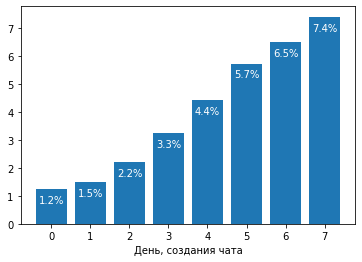

In [11]:
bars = plt.bar(x=df['days'], height=df['percentage'])
for i, value in enumerate(df['percentage'].values):
    v = str(np.around(value, decimals=1)) + '%'
    plt.text(i, value-0.5, v, ha='center', color='white')
plt.xlabel('День, создания чата');